https://archive.ics.uci.edu/dataset/2/adult

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import semopy

import matplotlib.pyplot as plt

from lingam import DirectLiNGAM
from lingam.utils import make_dot, remove_effect, calculate_total_effect, print_causal_directions, print_dagc
from lingam.bootstrap import BootstrapResult

import networkx as nx
import graphviz as gv
from IPython.display import display, Image, Markdown

np.random.seed(0)

## 準備

In [2]:
import requests

def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w") as f:
        f.write(res.text)

dirname = "ada_log_reg"
if os.path.isdir(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)

_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/_adaptive_logistic_regression.py", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/adaptive_logistic_regression.r", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/__init__.py", dirname=dirname)

from ada_log_reg import predict_adaptive_logistic_regression

In [3]:
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils import check_array
from lingam.utils import remove_effect

def run_analysis(X, exog_var_names, endog_var_names, sink_var_name, cd_model=None, sink_model=None):
    """
    X : pandas.DataFrame
        型はfloatまたはintであること。intは離散変数と解釈する。
    exog_var_names : list of str
        外生変数と仮定する変数のリスト。
    endog_var_names : list of str
        内生変数のリスト。
    sink_var_name : str
        シンク変数のリスト
    cd_model : object
        LiNGAMのインスタンス。必要なら事前知識など登録しておく。
    sink_model : object
        シンク変数へのエッジ係数を算出する際に用いるモデル。例えばシンクが離散ならばLogisticRegressionやAdaptiveLogisticRegressionなど。
        AdaptiveLogisticRegressionはpipできないため、インスタンス作成をユーザに任せる。
    """
    # Xの確認
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X must be padnas.DataFrame.")
    
    # 変数名リストの確認
    if len(set(exog_var_names) - set(X.columns)) > 0:
        raise ValueError("exog_var_names includes unknown variables.")
       
    if len(set(endog_var_names) - set(X.columns)) > 0:
        raise ValueError("endog_var_names includes unknown variables.")
        
    if len(set([sink_var_name]) - set(X.columns)) > 0:
        raise ValueError("sink_var_name is unknown variables.")

    # cd_modelのチェック
    if cd_model is None:
        cd_model = DirectLiNGAM()
    else:
        if isinstance(cd_model, DirectLiNGAM):
            pass
        else:
            # 他のクラスは未対応
            raise ValueError("cd_model must be a instance of following classes: DirectLiNGAM, ")
    
    # sink_modelのチェックはしない。
    
    # Xの処理
    exog_indices = [X.columns.tolist().index(v) for v in exog_var_names]
    endog_indices = [X.columns.tolist().index(v) for v in endog_var_names]
    sink_index = X.columns.tolist().index(sink_var_name)
    
    is_discrete = X.dtypes == int
    if is_discrete[endog_indices].any():
        raise ValueError("endog_var_names mustn't be a discrete variable. Convert types of variables specified in endog_var_names.")
    
    names = X.columns.tolist()
    
    X = check_array(X, copy=True)
    
    if sink_model is None:
        if is_discrete[sink_index]:
            sink_model = LogisticRegression()
        else:
            sink_model = LinearRegression()
    
    # 因果探索
    X_removed_exog = remove_effect(X, exog_indices)
    X_endog = X_removed_exog[:, endog_indices]
    
    cd_model.fit(X_endog)
    
    # シンク変数のモデル
    sink_model.fit(X[:, endog_indices], X[:, sink_index])
    sink_coef = sink_model.coef_

    # 隣接行列の作成
    adj = np.concatenate([cd_model.adjacency_matrix_, sink_coef])
    adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)

    cols = [names[i] for i in [*endog_indices, sink_index]]
    adj = pd.DataFrame(adj, columns=cols, index=cols)
    
    return adj

## データ読み込み

In [4]:
dirname = "adult_data"
os.listdir(dirname)

['adult.test', 'old.adult.names', 'Index', 'adult.data', 'adult.names']

In [5]:
with open(dirname + os.sep + "adult.names") as f:
    names_text = f.read()
print(names_text)

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over

In [6]:
data_df = pd.read_csv("adult_data/adult.data", sep=", ", engine="python", header=None)

# カラム名
columns = names_text.split("\n")[-data_df.shape[1]:]
columns = [c.split(":")[0] for c in columns]
columns[-1] = "income"
data_df.columns = columns

# 欠測
data_df[data_df == "?"] = np.nan

print(data_df.dtypes)

data_df

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## 欠測について
欠測に偏りがないか見ておく。

In [7]:
data_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

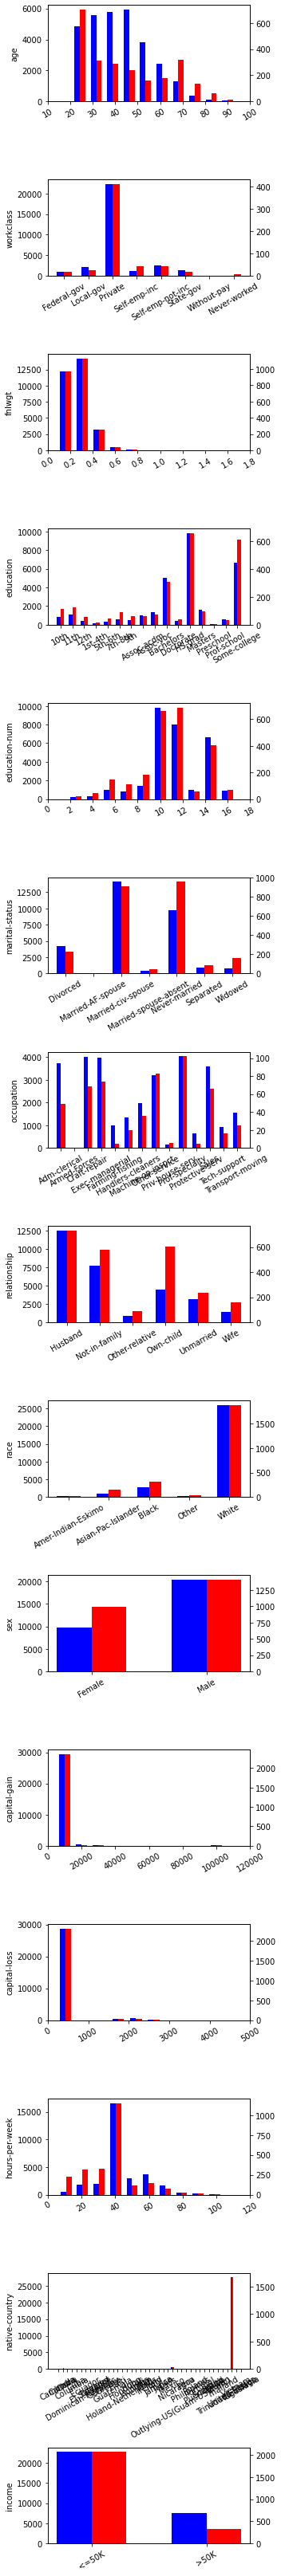

In [8]:
# 欠測の様子
filter_ = data_df.isna().sum(axis=1).astype(bool)

fig, axes = plt.subplots(data_df.shape[1], 1, figsize=(5, data_df.shape[1]*3))

for i in range(data_df.shape[1]):
    no_lacks = data_df[~filter_].iloc[:, i]
    lacks = data_df[filter_].iloc[:, i]
    
    if no_lacks.dtype != "object":
        range_ = min(*no_lacks, *lacks), max(*no_lacks, *lacks)
    
        bins, edges = np.histogram(no_lacks, range=range_)
        bins2, _ = np.histogram(lacks, range=range_)

        width = (edges[1] - edges[0]) / 3
        axes[i].bar(edges[1:] - width/2, bins, width=width, color="blue")
        axes[i].twinx().bar(edges[1:] + width/2, bins2, width=width, color="red")
    else:
        values, counts = np.unique(no_lacks, return_counts=True)
        series = pd.Series(counts, index=values)
        values, counts = np.unique(lacks.dropna(), return_counts=True)
        series2 = pd.Series(counts, index=values)
        df = pd.concat([series, series2], axis=1)
        
        axes[i].bar(np.arange(len(df))-0.15, df.iloc[:, 0], width=0.3, color="blue")
        axes[i].set_xticks(np.arange(len(df)))
        axes[i].set_xticklabels(df.index, rotation=30)
        
        ax = axes[i].twinx()
        ax.bar(np.arange(len(df))+0.15, df.iloc[:, 1], width=0.3, color="red")
        ax.set_xticks(np.arange(len(df)))
        ax.set_xticklabels(df.index, rotation=30)

    axes[i].set_ylabel(data_df.columns[i])
    
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30)

plt.tight_layout()
plt.show()

欠測が発生しているのは職業や元の国籍の部分で、年齢が高齢だったり、女性だったり、労働時間が短かったり、年収が50K超えなかったりというケースで欠測が発生が多い様子である。

とりあえず消すので、以下、これらの人々はいなかったことになる。

In [9]:
print(data_df.shape)
data_df = data_df.dropna()
print(data_df.shape)

(32561, 15)
(30162, 15)


## 因果探索の準備

連続値をfloat型にする。

In [10]:
data_df = data_df.astype({c:float for c in data_df.columns[data_df.dtypes == "int64"]})

カテゴリ変数を0/1にしたいので2値化する。

In [11]:
# workclass: 民間企業勤めかどうか
data_df.loc[:, "workclass"] = (data_df["workclass"] == "Private")
data_df.loc[:, "workclass"] = data_df["workclass"].apply(int).astype(int)

# fnlwgt: 何らかの分析に使う重みらしい。削除。
data_df = data_df.drop("fnlwgt", axis=1)

# education: 大学かどうか
data_df["education"] = (
    (data_df["education"] == "Bachelors") | (data_df["education"] == "Masters") | (data_df["education"] == "Doctorate")
).astype(int)

# marital-status: 結婚しているかどうか
data_df["marital-status"] = (
    (data_df["marital-status"] == "Never-married") | (data_df["marital-status"] == "Divorced") | (data_df["marital-status"] == "Widowed")
).astype(int)

# 職業：2値化できないので消す
data_df = data_df.drop("occupation", axis=1)

# relationship: marital-statusと似ているので子供がいるかどうか
data_df["relationship"] = (data_df["relationship"] == "Own-child").astype(int)

# race: 白人かどうか
data_df["race"] = (data_df["race"] == "White").astype(int)

# sex: 男かどうか
data_df["sex"] = (data_df["sex"] == "Male").astype(int)

# native_country: 米国かどうか
data_df["native-country"] = (data_df["native-country"] == "United-States").astype(int)

# income: 高収入かどうか
data_df["income"] = (data_df["income"] == ">50K").astype(int)

# 最後にもう一回変換しないと型が変わらない。
data_df["workclass"] = data_df["workclass"].apply(int)

In [12]:
data_df.dtypes

age               float64
workclass           int64
education           int64
education-num     float64
marital-status      int64
relationship        int64
race                int64
sex                 int64
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country      int64
income              int64
dtype: object

In [13]:
# 外生とシンク
exog_var_names = ["age", "sex", "race", "education", "education-num", "native-country"]
sink_var_name = "income"

# 残りは内生
endog_var_names = list(set(data_df.columns.tolist()) - set(exog_var_names) - set([sink_var_name]))

# ただし内生から離散は取り除く
for c, d in data_df.dtypes[endog_var_names].items():
    if d == "float":
        continue
    endog_var_names.remove(c)

print("exogenous:", exog_var_names)
print("endogenous", endog_var_names)

exogenous: ['age', 'sex', 'race', 'education', 'education-num', 'native-country']
endogenous ['capital-gain', 'hours-per-week', 'capital-loss']


典型例のプログラムを実行する。

In [14]:
result = run_analysis(data_df, exog_var_names, endog_var_names, sink_var_name, cd_model=None, sink_model=None)
result

,capital-gain,hours-per-week,capital-loss,income
capital-gain,0.000000,0.000000,-0.888077,0.0
hours-per-week,0.000076,0.000000,0.000821,0.0
capital-loss,0.000000,0.000000,0.000000,0.0
income,0.000344,0.043613,0.000811,0.0
